In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from itertools import islice
from scipy import stats
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.utils.class_weight import compute_sample_weight

import preprocessing
import tests
import models

DATA_FILE = "data.csv"
sns.set_theme(style="whitegrid")


# Reading in Data

In [2]:
# preproccess() #also removes any missing values replacing them with NaN
preprocessing.preproccess()
df = pd.read_csv(DATA_FILE)

# Cleaning the Data

In [3]:
# remove rows containing AGEGP = 1, 2, 3 and 4 to restrict analysis on ages 18+
df = df.loc[df["AGEGP"] > 4]
# keep rows where people make more than 0 income
df = df.loc[df['ATINC'] > 0]
# keep rows where people have more than 0 wages and salaries 
df = df.loc[df['WGSAL'] > 0]
# keep rows where people have more than 0 income tax 
df = df.loc[df['INCTX'] > 0]
# sorting by after tax income
df = df.sort_values(by=['ATINC'])
# selecting relevant variables 
df = df[["PROV", "AGEGP", "SEX", "MARSTP", "HLEV2G", "SCSUM", "USHRWK", "IMMST", "MAJRI", "ATINC", "INCTX", "WGSAL"]]  
# drop any missing values 
df = df.dropna()
# viewing first few lines of dataframe 
df.head()

,PROV,AGEGP,SEX,MARSTP,HLEV2G,SCSUM,USHRWK,IMMST,MAJRI,ATINC,INCTX,WGSAL
43864,35.0,13.0,1.0,1.0,4.0,12.0,15.0,2.0,2.0,250.0,4650.0,2800.0
76174,35.0,12.0,2.0,1.0,3.0,11.0,80.0,2.0,2.0,440.0,60.0,100000.0
69759,59.0,13.0,2.0,1.0,2.0,22.0,12.0,2.0,4.0,1160.0,3390.0,1800.0
84275,24.0,12.0,1.0,2.0,1.0,11.0,60.0,2.0,2.0,1240.0,4760.0,6000.0
83158,47.0,8.0,2.0,1.0,4.0,22.0,3.0,2.0,2.0,1400.0,32250.0,33000.0


In [4]:
# making a copy of the dataframe to retain numeric values instead of strings for our model implementation later on
df_m = df.copy(deep=True)
# dropping other numerical variables as we are classifying after tax income based on demographic for our models
df_m = df_m.drop(columns = ['INCTX','WGSAL'])

# mapping groups from numeric to string
df = preprocessing.map_val(df)

# Categorical variables
cat_features = df[["PROV", "AGEGP", "SEX", "MARSTP", "HLEV2G", "SCSUM", "IMMST", "USHRWK", "MAJRI"]]

# Feature names for our plots
values = ["Province", "Age Group", "Gender", "Marital Status", "Highest Level of Education", "Yearly Summary of Time Worked", "Immigration Status", "Average Hours Worked per Week", "Major Source of Income"]
cat_dict = dict(zip(cat_features.columns, values))

# Log transforming data due to the distribution of variables being right skewed 
dflog = df.copy(deep=True)
logged_vars= dflog[["ATINC", "INCTX", "WGSAL"]].apply(lambda x: np.log(x))
dflog[["ATINC", "INCTX", "WGSAL"]] = logged_vars

# displaying the categorical variables mapped to their corresponding string 
cat_features

,PROV,AGEGP,SEX,MARSTP,HLEV2G,SCSUM,IMMST,USHRWK,MAJRI
43864,ON,60-64,Male,Married,University Degree,Full-Year Part-Time,Non-Immigrant,15.0,Wages and Salary
76174,ON,55-59,Female,Married,Certificate or Diploma,Full-Year Full-Time,Non-Immigrant,80.0,Wages and Salary
69759,BC,60-64,Female,Married,Graduated HS,Part-Year Part-Time,Non-Immigrant,12.0,Government Transfers
84275,QU,55-59,Male,Common-Law,Less than HS,Full-Year Full-Time,Non-Immigrant,60.0,Wages and Salary
83158,SA,35-39,Female,Married,University Degree,Part-Year Part-Time,Non-Immigrant,3.0,Wages and Salary
...,...,...,...,...,...,...,...,...,...
52158,ON,55-59,Male,Married,University Degree,Full-Year Full-Time,Immigrant,40.0,Wages and Salary
46578,ON,45-49,Male,Married,University Degree,Full-Year Full-Time,Non-Immigrant,75.0,Wages and Salary
37117,ON,70+,Male,Married,University Degree,Full-Year Full-Time,Non-Immigrant,44.0,Investment
86503,ON,50-54,Male,Married,University Degree,Full-Year Full-Time,Immigrant,40.0,Wages and Salary


# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35466 entries, 43864 to 9818
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PROV    35466 non-null  object 
 1   AGEGP   35466 non-null  object 
 2   SEX     35466 non-null  object 
 3   MARSTP  35466 non-null  object 
 4   HLEV2G  35466 non-null  object 
 5   SCSUM   35466 non-null  object 
 6   USHRWK  35466 non-null  float64
 7   IMMST   35466 non-null  object 
 8   MAJRI   35466 non-null  object 
 9   ATINC   35466 non-null  float64
 10  INCTX   35466 non-null  float64
 11  WGSAL   35466 non-null  float64
dtypes: float64(4), object(8)
memory usage: 3.5+ MB


In [6]:
# Summary of numerical variables
df[['ATINC','INCTX','WGSAL']].describe().round(2)

,ATINC,INCTX,WGSAL
count,35466.00,35466.00,35466.00
mean,57167.20,13381.62,62109.14
std,36354.76,19159.59,50515.87
min,250.00,10.00,25.00
25%,35351.25,4060.00,32000.00
50%,49270.00,8520.00,50000.00
75%,69710.00,16370.00,80000.00
max,922020.00,561330.00,1250000.00


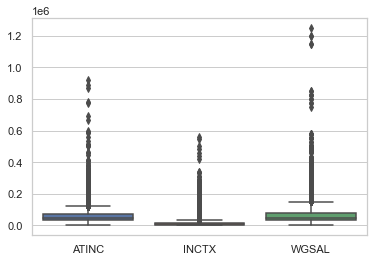

In [7]:
# Boxplot of data 
sns.boxplot(data=df[["ATINC", "INCTX", "WGSAL"]]);

In [8]:
# Correlation matrix 
df[["ATINC", "INCTX", "WGSAL"]].corr()

,ATINC,INCTX,WGSAL
ATINC,1.000000,0.866356,0.900130
INCTX,0.866356,1.000000,0.868409
WGSAL,0.900130,0.868409,1.000000


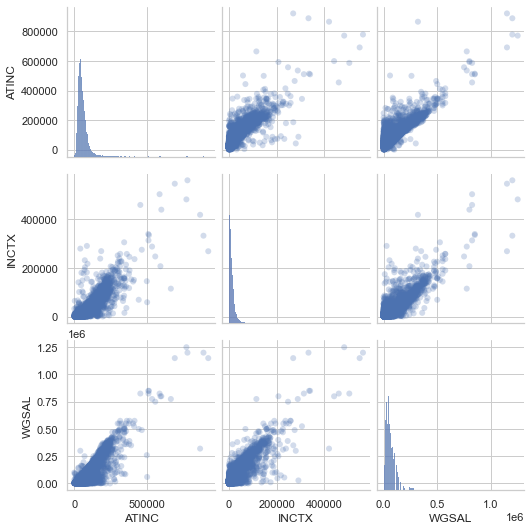

In [9]:
# Matrix scatter plot of data
sns.pairplot(df[["ATINC", "INCTX", "WGSAL"]],plot_kws=dict(edgecolor="none", alpha=0.25));

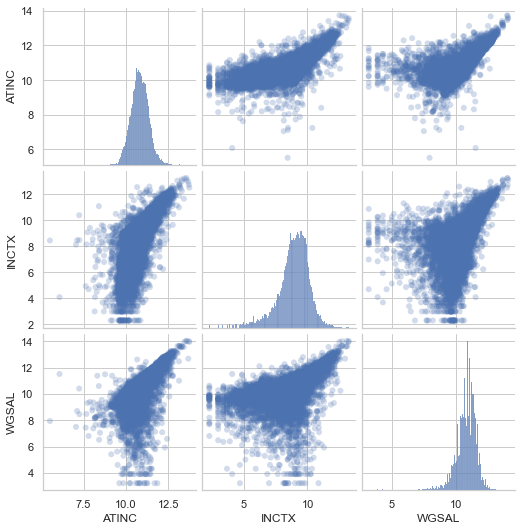

In [10]:
# Matrix scatter plot of log transformed data 
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL"]], plot_kws=dict(edgecolor="none", alpha=0.25));

PROV has 10 unique elements:
 ['ON' 'BC' 'QU' 'SA' 'AB' 'NB' 'NL' 'MA' 'NS' 'PE']
The distributions:
ON    27.86%
QU    18.54%
AB    11.43%
BC     11.1%
MA     7.94%
SA     7.07%
NB     5.03%
NS     4.83%
NL     3.51%
PE     2.69%
Name: PROV, dtype: object


AGEGP has 11 unique elements:
 ['60-64' '55-59' '35-39' '45-49' '30-34' '50-54' '18-24' '40-44' '65-69'
 '25-29' '70+']
The distributions:
50-54    12.72%
55-59    12.69%
35-39     11.6%
45-49    11.56%
30-34    11.25%
40-44    11.12%
60-64     9.23%
25-29      8.7%
18-24      6.0%
65-69     3.96%
70+       1.17%
Name: AGEGP, dtype: object


SEX has 2 unique elements:
 ['Male' 'Female']
The distributions:
Male      53.89%
Female    46.11%
Name: SEX, dtype: object


MARSTP has 4 unique elements:
 ['Married' 'Common-Law' 'Single' 'Separated']
The distributions:
Married       54.65%
Single        21.59%
Common-Law    15.47%
Separated      8.29%
Name: MARSTP, dtype: object


HLEV2G has 4 unique elements:
 ['University Degree' 'Certific

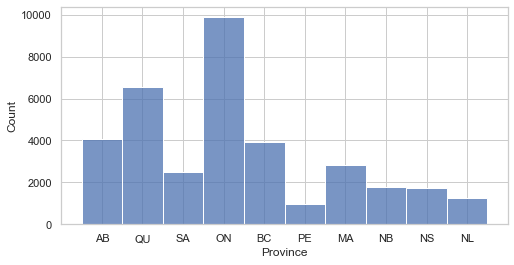

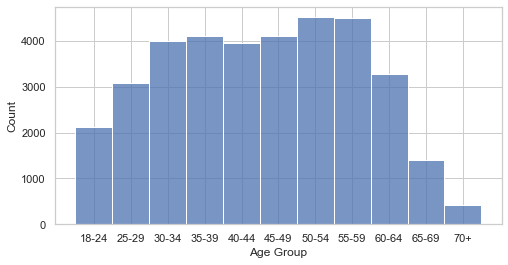

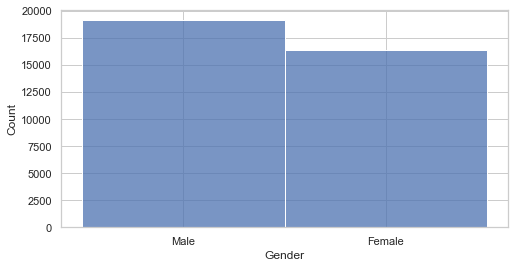

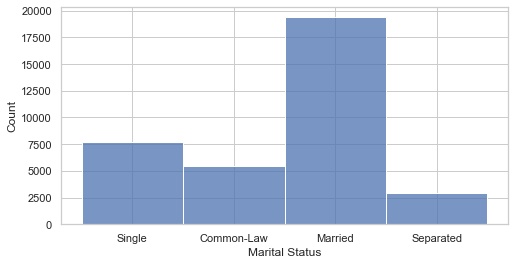

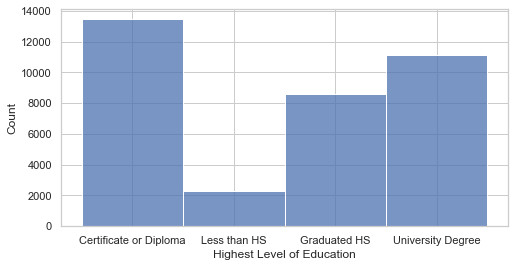

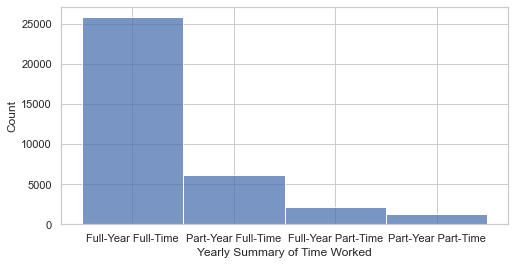

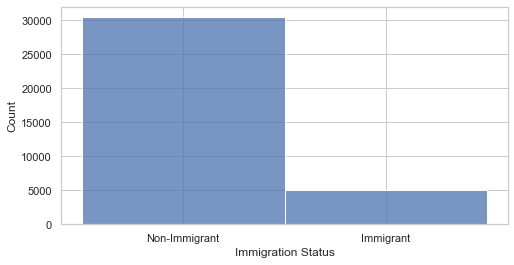

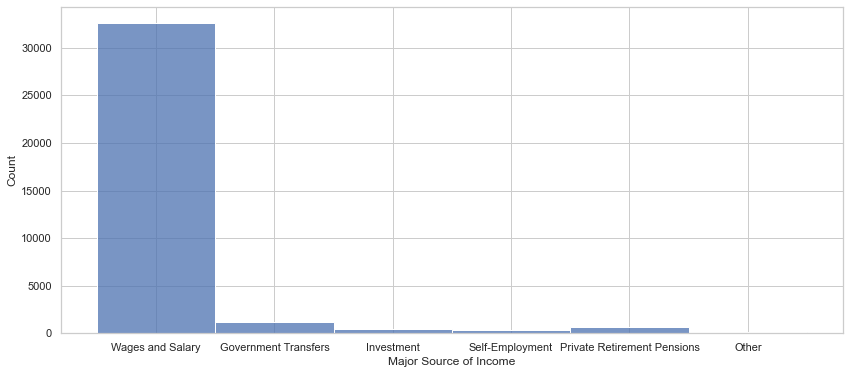

In [11]:
# distribution of the groups in each of the categorical variables
for col in list(cat_features.columns):
    print(col +' has '+ str(cat_features[col].nunique()) +' unique elements:\n ' + str(cat_features[col].unique())) 
    print('The distributions:')
    print(round(df[col].value_counts(normalize=True)*100,2).map(str)+'%') 
    print('\n')

# Visualizations for the distribution of the groups in each of our categorical variables
rcParams['figure.figsize'] = 8,4
for features in cat_features:
    if features != 'USHRWK':
        if features == 'MAJRI':
            rcParams['figure.figsize'] = 14,6
            sns.histplot(data=df, x=features).set(xlabel=cat_dict[features]);
            plt.show()
        else:
            rcParams['figure.figsize'] = 8,4
            sns.histplot(data=df.sort_values(by='AGEGP'), x=features).set(xlabel=cat_dict[features]);
            plt.show()

## Statistical tests

### T-Tests 

T-Test p-value: 1.946139690523835e-285


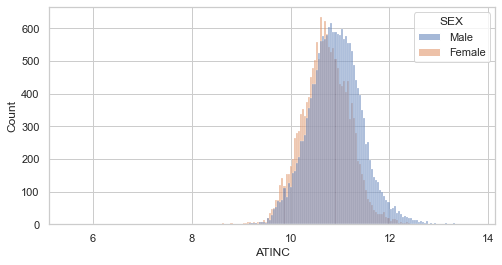

In [15]:
# Test to determine whether an individuals after tax income is affected by their gender.
rcParams['figure.figsize'] = 8,4 
tests.income_gender(dflog)
# since the p-value < 0.05, there is sufficient evidence to reject the null hypothesis that both male and female after tax income are the same 
# therefore we conclude the income for male and females are different

T-Test p-value: 6.291075077018407e-205
Female income mean: 54333.2
Male income mean: 67510.85
Female income median: 48765.0
Male income median: 58520.0
Percent female respondants who work full time full year: 70.32%
Percent male respondants who work full time full year: 74.84%


,ATINC
SEX,
Female,50
Male,304


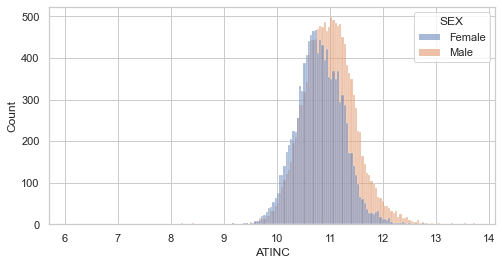

In [16]:
# T-test to determine whether an individuals whose full-year full-time after tax income is affected by their gender 
temp = dflog.loc[dflog['SCSUM'] == 'Full-Year Full-Time']
tests.income_gender(temp)

temp = df[['SEX', 'SCSUM', 'ATINC']]
temp = temp.loc[temp['SCSUM'] == 'Full-Year Full-Time']
female = temp.loc[temp['SEX'] == 'Female']
male = temp.loc[temp['SEX'] == 'Male']
print('Female income mean:',round(female['ATINC'].mean(),2))
print('Male income mean:',round(male['ATINC'].mean(),2))
print('Female income median:',round(female['ATINC'].median(),2))
print('Male income median:',round(male['ATINC'].median(),2))
temp = df[['SEX', 'SCSUM']]
fTotal = temp.loc[temp['SEX'] == 'Female']
mTotal = temp.loc[temp['SEX'] == 'Male']
print('Percent female respondants who work full time full year:',np.format_float_positional(round(100*female.shape[0]/fTotal.shape[0],2))+'%')
print('Percent male respondants who work full time full year:',np.format_float_positional(round((100*male.shape[0]/mTotal.shape[0]),2))+'%')

# outputting top 1% of male and female earners
df[['SEX','ATINC']].tail(int(len(df)*(1/100))).groupby('SEX').count()

T-test p-value: 0.01082887515068066
Immigrant income mean: 61737.69
Non-Immigrant income mean: 61621.31
Immigrant income median: 51310.0
Non-Immigrant income median: 54065.0
Percent Immigrant respondants who work full time full year: 74.88%
Percent Non-Immigrant respondants who work full time full year: 72.4%
top 2% immigrant and non-immigrant earners:
                ATINC
IMMST               
Immigrant        117
Non-Immigrant    592


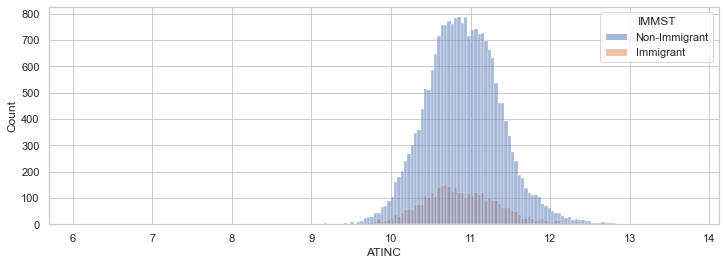

In [33]:
# T-test to determine whether an individuals whose full-year full-time after tax income is affected by their immigration status 
temp = dflog.loc[dflog['SCSUM'] == 'Full-Year Full-Time']
tests.imm_income(temp)

temp = df[['IMMST', 'SCSUM', 'ATINC']]
temp = temp.loc[temp['SCSUM'] == 'Full-Year Full-Time']
imm = temp.loc[temp['IMMST'] == 'Immigrant']
non_imm = temp.loc[temp['IMMST'] == 'Non-Immigrant']
print('Immigrant income mean:',round(imm['ATINC'].mean(),2))
print('Non-Immigrant income mean:',round(non_imm['ATINC'].mean(),2))
print('Immigrant income median:',round(imm['ATINC'].median(),2))
print('Non-Immigrant income median:',round(non_imm['ATINC'].median(),2))
temp = df[['IMMST', 'SCSUM']]
fTotal = temp.loc[temp['IMMST'] == 'Immigrant']
mTotal = temp.loc[temp['IMMST'] == 'Non-Immigrant']
print('Percent Immigrant respondants who work full time full year:',np.format_float_positional(round(100*imm.shape[0]/fTotal.shape[0],2))+'%')
print('Percent Non-Immigrant respondants who work full time full year:',np.format_float_positional(round((100*non_imm.shape[0]/mTotal.shape[0]),2))+'%')

# outputting top 2% of immigrant and non-immigrant earners
print('top 2% immigrant and non-immigrant earners:\n',df[['IMMST','ATINC']].tail(int(len(df)*(2/100))).groupby('IMMST').count())

T-test p-value: 0.07501368910197094


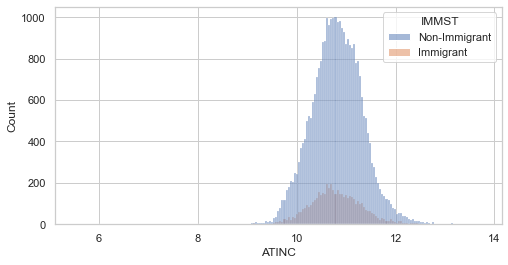

In [18]:
# Test to determine whether the after tax income for immigrants is different than non-immigrants 
tests.imm_income(dflog)
# p-value > 0.05, so we can conclude the after tax income for immigrants and non-immigrants are not different

### ANOVA and Post Hoc Analaysis

ANOVA p-value: 0.0
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
   common_law       married    0.122 0.001  0.1019   0.142   True
   common_law never_married  -0.1978 0.001  -0.221 -0.1746   True
   common_law     seperated   0.0596 0.001  0.0296  0.0895   True
      married never_married  -0.3197 0.001 -0.3374  -0.302   True
      married     seperated  -0.0624 0.001 -0.0883 -0.0364   True
never_married     seperated   0.2573 0.001  0.2289  0.2858   True
-----------------------------------------------------------------


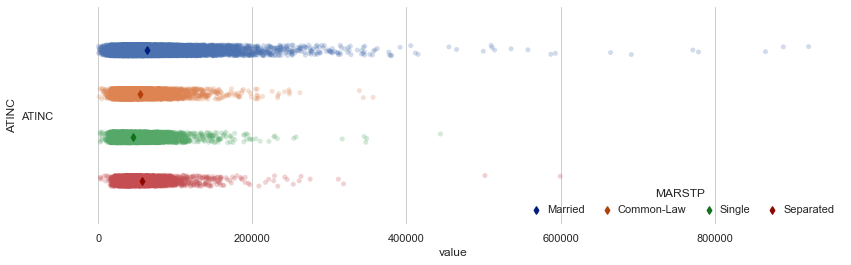

In [19]:
# ANOVA test to determine if the after tax income of marital status differs
tests.anova(dflog)
# p-value < 0.05 hence we have sufficient evidence to reject the null hypothesis that the means of the groups are the same
# to conclude, the means of the groups are different 
rcParams['figure.figsize'] = 14,4  
tests.stripplot(df[['MARSTP', 'ATINC']], 'ATINC', 'MARSTP')


ANOVA p-value: 2.1212978076237384e-258 

                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
           group1                      group2           meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------
       Government Transfers                  Investment   0.7975  0.001  0.7179  0.8771   True
       Government Transfers                       Other   0.5674  0.001  0.4494  0.6853   True
       Government Transfers Private Retirement Pensions   0.5566  0.001  0.4845  0.6288   True
       Government Transfers             Self-Employment   0.3813  0.001  0.2917   0.471   True
       Government Transfers            Wages and Salary   0.4972  0.001  0.4527  0.5417   True
                 Investment                       Other  -0.2302  0.001 -0.3583  -0.102   True
                 Investment Private Retirement Pensions  -0.2409  0.001 -0.3287 -0.1531   True
        

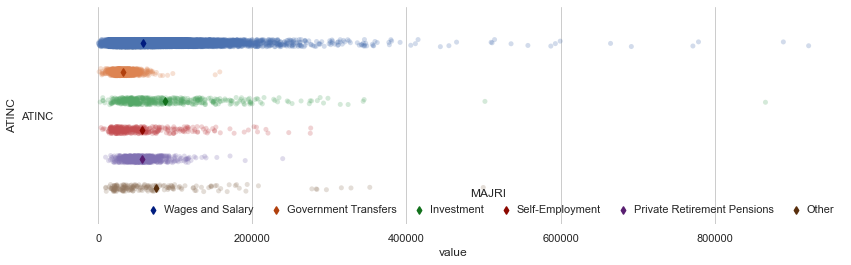

In [20]:
# Test to determine peoples major source of income difference 
tests.major_source(dflog)
# p-value < 0.05 hence we have sufficient evidence to reject the null hypothesis that the means of the groups are the same
# to conclude, the means of the groups are different 
rcParams['figure.figsize'] = 14,4  
tests.stripplot(df[['MAJRI', 'ATINC']], 'ATINC', 'MAJRI')



ANOVA p-value: 0.0 

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
        group1               group2      meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------------
Certificate or Diploma      Graduated HS  -0.1751 0.001 -0.1928 -0.1573   True
Certificate or Diploma      Less than HS  -0.2141 0.001 -0.2432 -0.1851   True
Certificate or Diploma University Degree   0.2254 0.001   0.209  0.2419   True
          Graduated HS      Less than HS   -0.039 0.005 -0.0693 -0.0088   True
          Graduated HS University Degree   0.4005 0.001   0.382   0.419   True
          Less than HS University Degree   0.4396 0.001  0.4101  0.4691   True
------------------------------------------------------------------------------
                        USHRWK     ATINC     INCTX      WGSAL
HLEV2G                                                       
Certificate or Diploma   120.0  593255.0  291100.0   800000.0
Gr

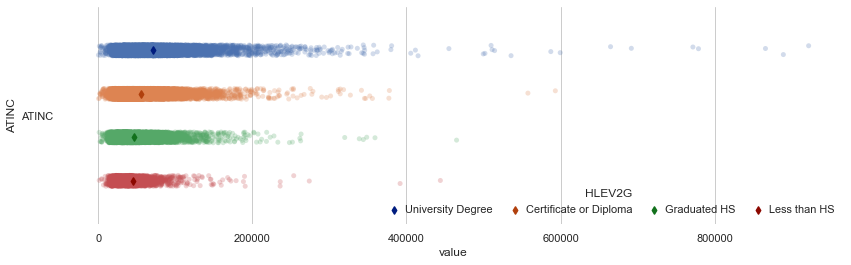

In [21]:
# Test to determine if incomes differ based on education level
tests.educ_level(dflog)
tests.stripplot(df[['HLEV2G', 'ATINC']], 'ATINC', 'HLEV2G')

temp = df.groupby('HLEV2G').max('ATINC')
print(temp)
temp = df.groupby('HLEV2G').mean('USHRWK')
print(temp)
temp = df.groupby('HLEV2G').median('USHRWK')
print(temp)
temp = df[['HLEV2G','ATINC']].tail(int(len(df)*(5/100))).groupby('HLEV2G').mean()
print(temp)

num = df.loc[df['SCSUM'] == 'Full-Year Full-Time']
perc = num.groupby('HLEV2G').count()/df.groupby('HLEV2G').count()
print(perc)

### Chi-Squared Test

In [22]:
# Test to determine whether marital status and highest level of education obtained are independent from each other 
# creating contingency table and output of chi square test
tests.chi_test(df, 'HLEV2G', 'MARSTP')
# since p-value < 0.05 we have sufficient evidence to reject the null hypothesis that the categories are independent
# Therefore, we can conclude the categories are indeed dependant on each other

MARSTP                  Common-Law  Married  Separated  Single
HLEV2G                                                        
Certificate or Diploma        2431     7101       1286    2653
Graduated HS                  1217     4130        707    2524
Less than HS                   367     1163        239     523
University Degree             1471     6989        709    1956
Chi-Squared Test p-value for HLEV2G and MARSTP: 8.734735313574795e-158


## Back To EDA

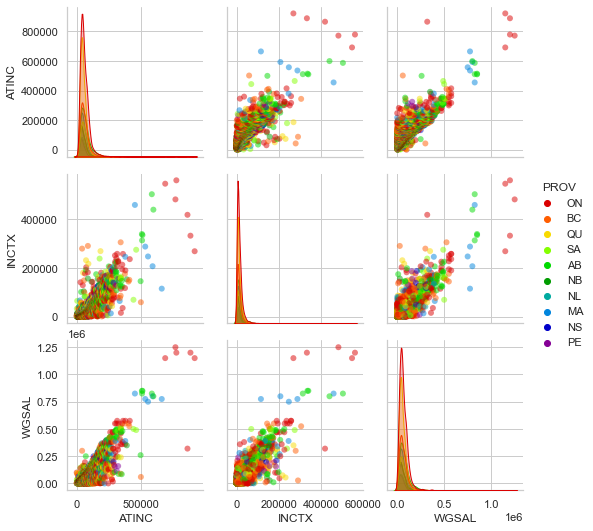

In [23]:
#sns.reset_defaults()
sns.pairplot(df[["ATINC", "INCTX", "WGSAL","PROV"]],hue="PROV",palette='nipy_spectral_r',plot_kws=dict(edgecolor="none",alpha=0.5));

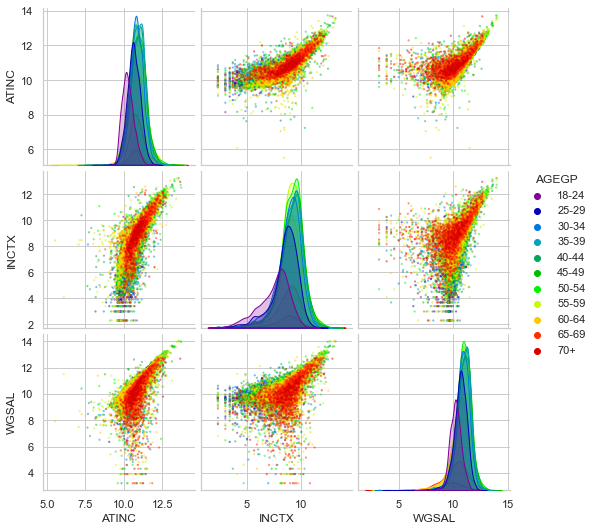

In [24]:
dflog = dflog.sort_values(by=['AGEGP'])
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","AGEGP"]],hue="AGEGP",palette='nipy_spectral', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

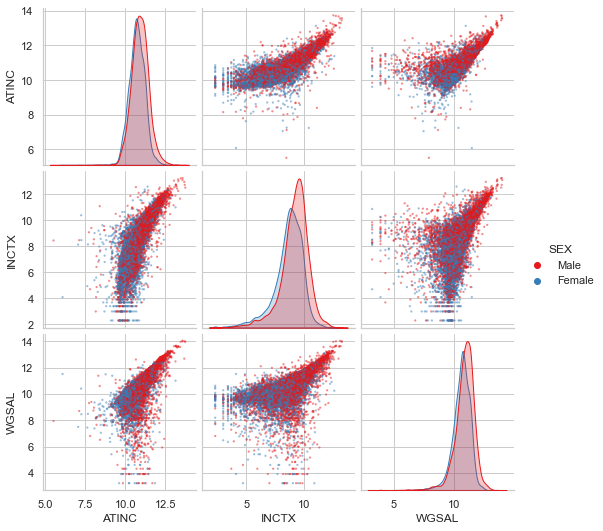

In [25]:
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","SEX"]],hue="SEX", palette='Set1', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

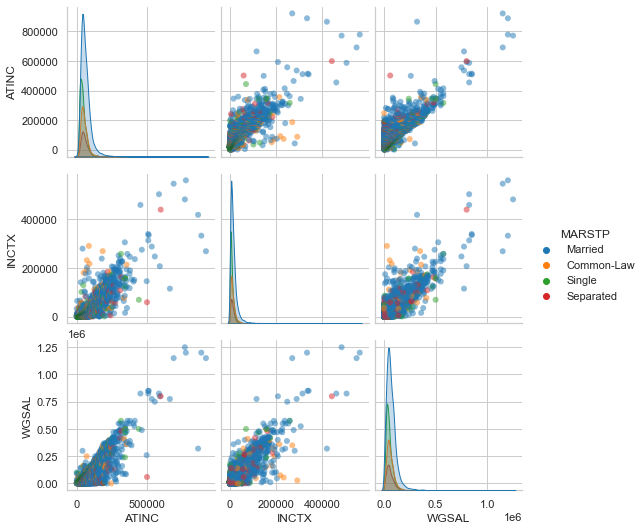

In [26]:
sns.pairplot(df[["ATINC", "INCTX", "WGSAL","MARSTP"]],hue="MARSTP",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5));

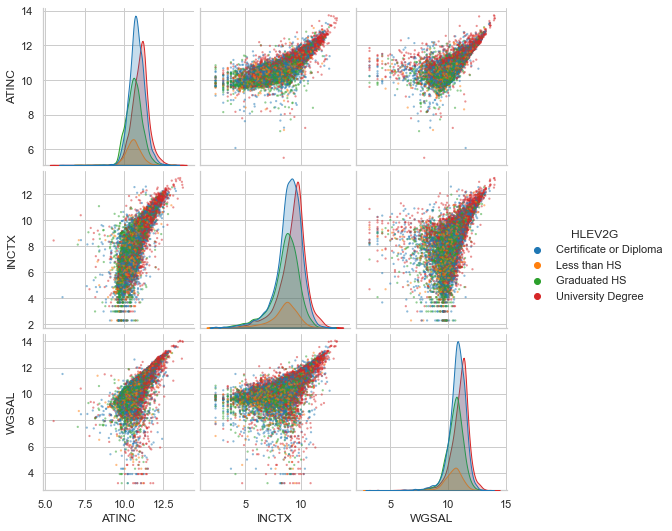

In [27]:
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","HLEV2G"]],hue="HLEV2G",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

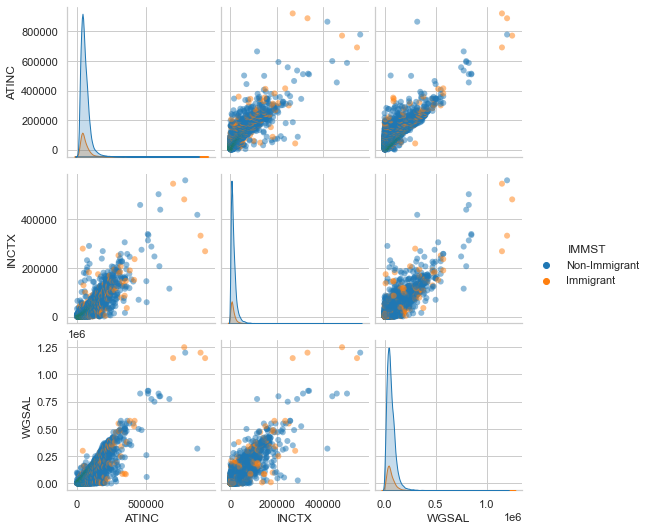

In [28]:
sns.pairplot(df[["ATINC", "INCTX", "WGSAL","IMMST"]],hue="IMMST",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5));

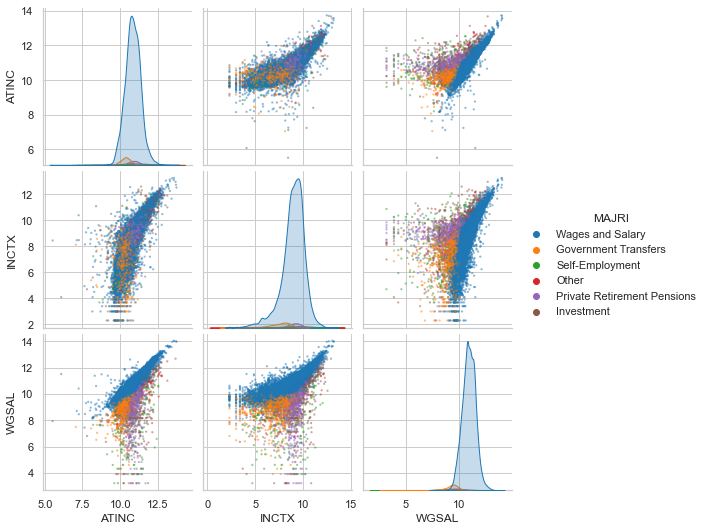

In [29]:
sns.pairplot(dflog[["ATINC", "INCTX", "WGSAL","MAJRI"]],hue="MAJRI",palette='tab10', plot_kws=dict(edgecolor="none",alpha=0.5, s=5));

         ATINC
PROV          
AB    67854.85
BC    60070.54
MA    53276.67
NB    50757.96
NL    53899.91
NS    51246.67
ON    59602.40
PE    47779.76
QU    50884.84
SA    60383.33 

          ATINC
AGEGP          
18-24  30660.40
25-29  45525.72
30-34  54035.98
35-39  60189.14
40-44  62910.47
45-49  63672.30
50-54  62216.25
55-59  60359.63
60-64  57046.84
65-69  59732.80
70+    63718.71 

           ATINC
SEX             
Female  50126.17
Male    63191.47 

               ATINC
MARSTP              
Common-Law  53783.89
Married     63000.08
Separated   57409.68
Single      44731.07 

                           ATINC
HLEV2G                          
Certificate or Diploma  55059.20
Graduated HS            46702.41
Less than HS            44478.65
University Degree       70402.78 

                        ATINC
SCSUM                        
Full-Year Full-Time  61638.28
Full-Year Part-Time  39913.67
Part-Year Full-Time  48390.00
Part-Year Part-Time  39626.36 

                  ATINC
IMMS

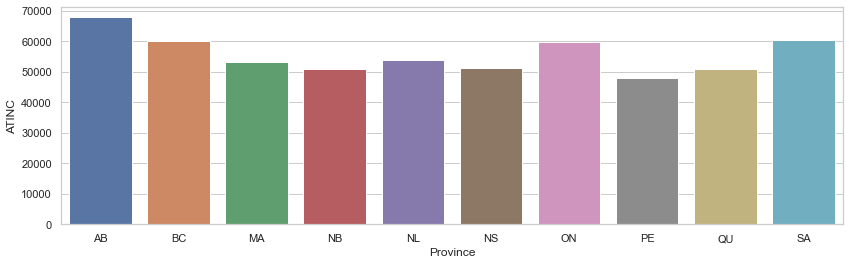

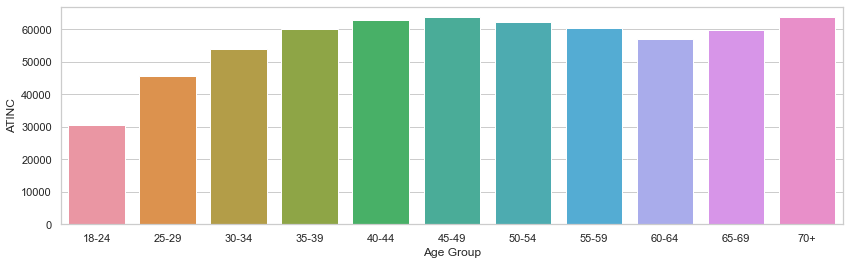

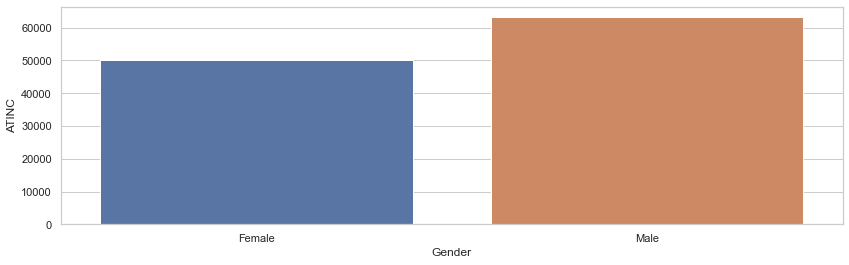

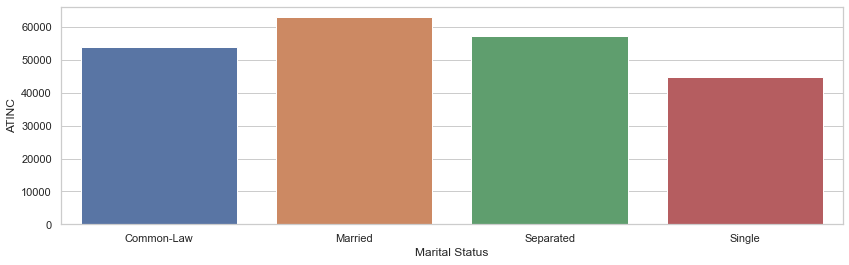

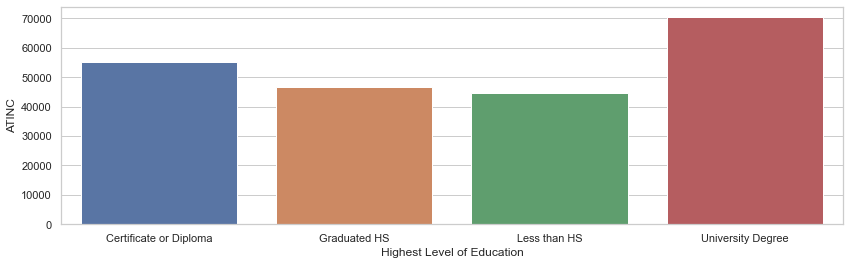

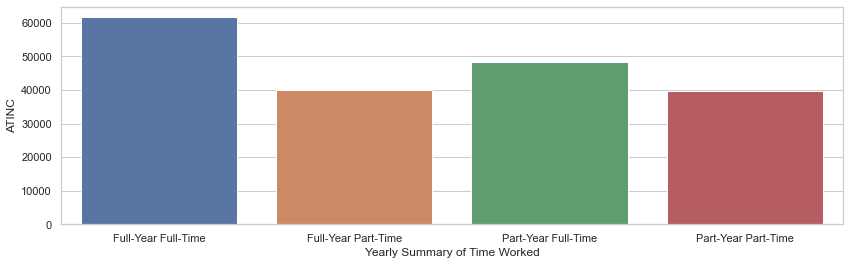

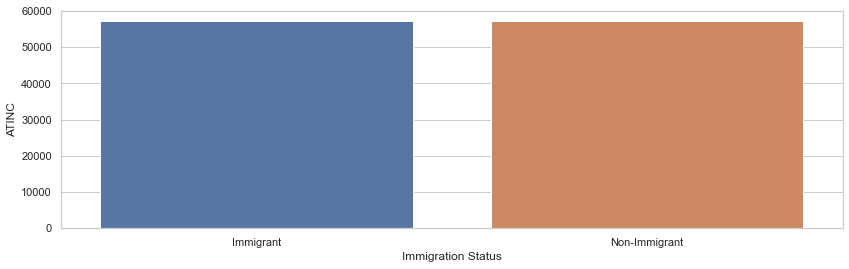

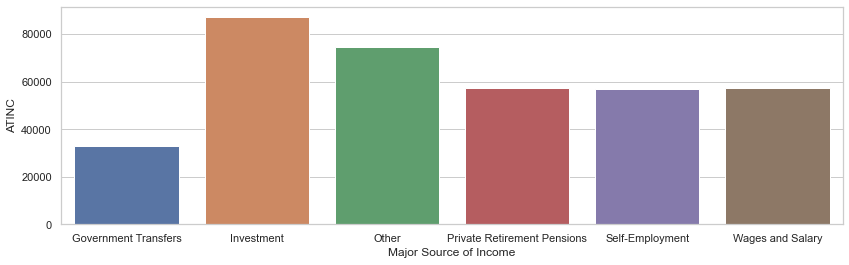

In [30]:
# Outputting mean after tax income for the groups in each categorical variable
for feature in cat_features:
    print(df[[feature, 'ATINC']].groupby(by=[feature]).mean().round(2),'\n')

# barplots for average after tax income for the different groups in each categorical variable 
for features in cat_features:
    rcParams['figure.figsize'] = 14,4 
    if features != 'USHRWK':
        group = df[[features, 'ATINC']].groupby(by=[features]).mean().round(2)
        sns.barplot(x=group.index, y=group['ATINC']).set(xlabel=cat_dict[features]);
        plt.show()

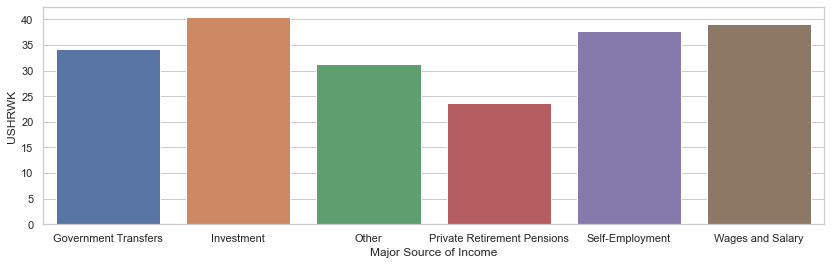

In [31]:
# Plot of average hours worked per week and major source of income 
rcParams['figure.figsize'] = 14,4
group = df[['MAJRI', 'USHRWK']].groupby(by=['MAJRI']).mean().round(2)
sns.barplot(x=group.index, y=group['USHRWK']).set(xlabel='Major Source of Income');

PROV  CLASS       
AB    Low             18.61%
      Lower-middle    20.29%
      Middle          24.93%
      Upper           10.59%
      Upper-middle    25.59%
BC    Low             23.23%
      Lower-middle    22.92%
      Middle          25.26%
      Upper            6.51%
      Upper-middle    22.08%
MA    Low             28.59%
      Lower-middle    26.49%
      Middle          24.64%
      Upper            3.34%
      Upper-middle    16.94%
NB    Low             32.44%
      Lower-middle    25.71%
      Middle          25.49%
      Upper             3.7%
      Upper-middle    12.66%
NL    Low             28.17%
      Lower-middle    26.73%
      Middle          22.71%
      Upper            4.01%
      Upper-middle    18.38%
NS    Low             30.06%
      Lower-middle    27.55%
      Middle          23.23%
      Upper            2.74%
      Upper-middle     16.4%
ON    Low             22.55%
      Lower-middle    24.24%
      Middle          24.68%
      Upper            5

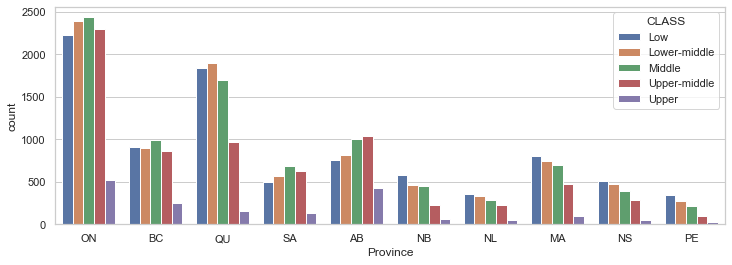

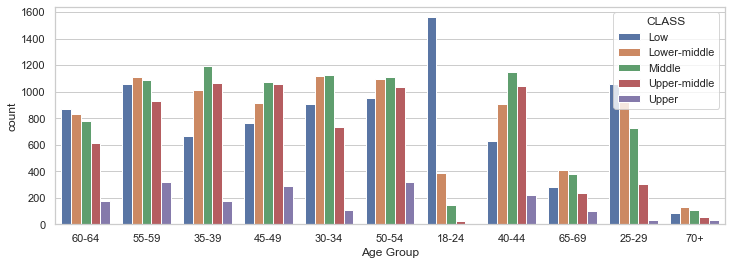

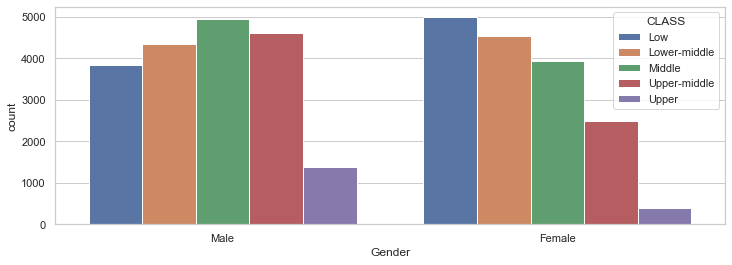

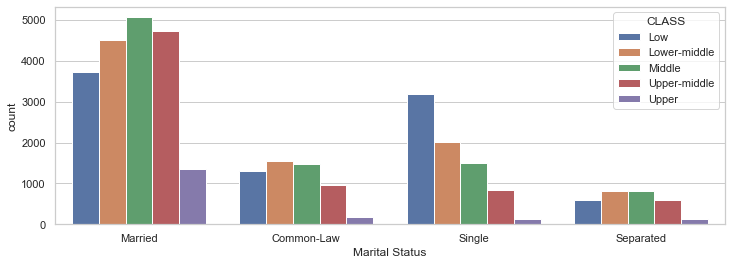

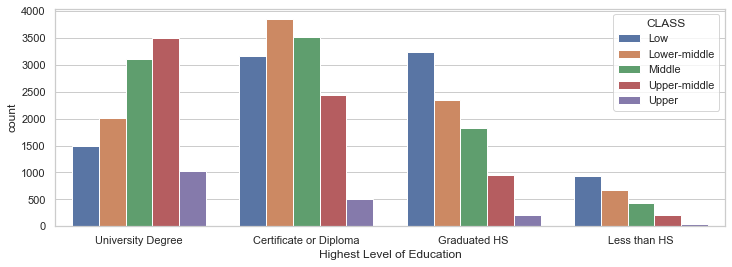

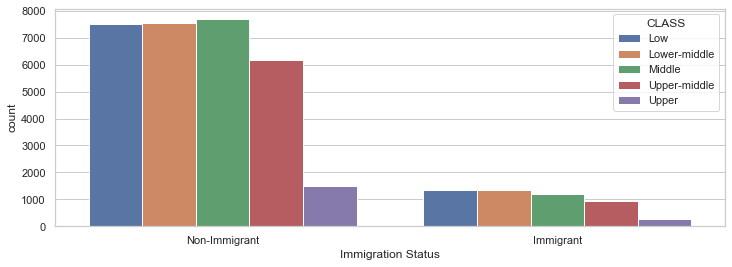

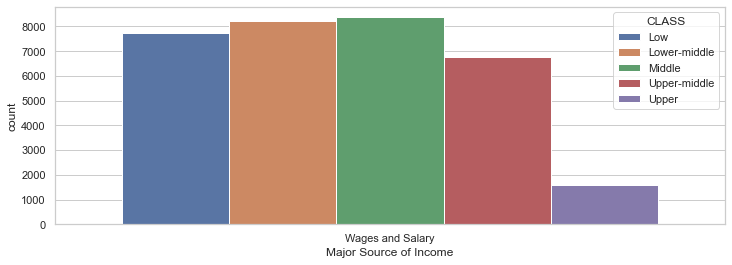

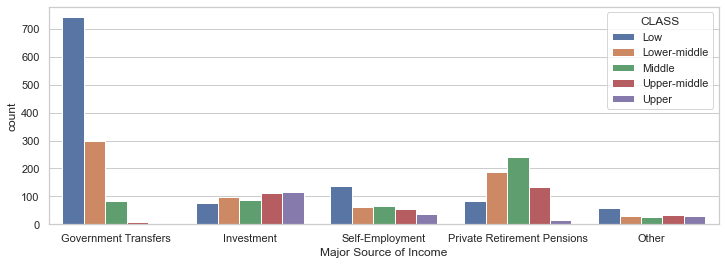

In [32]:
# classifying ATINC variable (after tax income), with our income_classifier function 
income=[]
income =(pd.concat([cat_features, df["ATINC"]], axis=1))
income['CLASS'] = income.apply(models.income_classifier, axis=1)

# Distribution of income classification for the groups in each of our categorical variables
for col in income.columns:
    x= income.groupby([col,'CLASS'])['CLASS'].count() # counting the income level class per group within a categorical variable
    y= income.groupby([col])['CLASS'].count() # counting the total number of income level class per group within a categorical variable
    r = round((x/y)*100,2).map(str)+'%' 
    print(r)
    print('\n')

# adding col to dataframes with income level classification 
df['CLASS'] = income['CLASS']
df_m['CLASS'] = income['CLASS']

# Visualizations of the distributions of income classification for the groups in each of our categorical variables
rcParams['figure.figsize'] = 12,4
df = df.sort_values(by=['ATINC'])
for features in cat_features:
    if (features != 'USHRWK') & (features != 'SCSUM'):
        if features == 'MAJRI':
            sns.countplot(data=df[df['MAJRI']=='Wages and Salary'],x=features, hue='CLASS').set(xlabel=cat_dict[features]);
            plt.show()
            sns.countplot(data=df[df['MAJRI']!='Wages and Salary'],x=features, hue='CLASS').set(xlabel=cat_dict[features]);
            plt.show()
        else:
            sns.countplot(data=df,x=features, hue='CLASS').set(xlabel=cat_dict[features]);
            plt.show()

In [34]:
# number of low income immigrants and non-immigrants 
low_imm = df[['IMMST','ATINC']].loc[df['CLASS']=='Low'].groupby('IMMST').count()
# total number of immigrants and non-immigrants
tot_imm = df[['IMMST','ATINC']].groupby('IMMST').count()

print('percentage of immigrants who are low income:',np.format_float_positional(round(low_imm.iloc[0]/tot_imm.iloc[0] * 100,2)) +'%')
print('percentage of non-immigrants who are low income:',np.format_float_positional(round(low_imm.iloc[1]/tot_imm.iloc[1] * 100,2)) +'%')

percentage of immigrants who are low income: 26.4%
percentage of non-immigrants who are low income: 24.66%


# Implementing Models

In [35]:
# Getting the data
X = df_m.drop(['ATINC','CLASS'], axis=1)
y = df_m['CLASS']

# Partition the data into trianing and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y)

# weights
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
dictionary = dict(zip(y_train, sample_weights))

### Naive Bayes Classifier

0.3838114214820106
0.3862636742979587
              precision    recall  f1-score   support

         Low       0.53      0.56      0.54      2208
Lower-middle       0.34      0.22      0.27      2220
      Middle       0.32      0.36      0.34      2219
Upper-middle       0.14      0.10      0.12       444
       Upper       0.37      0.48      0.42      1776

    accuracy                           0.39      8867
   macro avg       0.34      0.34      0.34      8867
weighted avg       0.38      0.39      0.38      8867



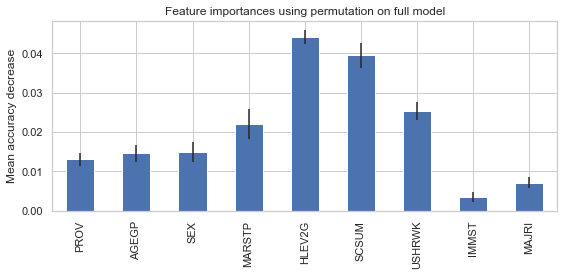

In [36]:
bayes_model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)
bayes_model.fit(X_train, y_train)
print(bayes_model.score(X_train, y_train))
print(bayes_model.score(X_valid, y_valid))
print(classification_report(y_valid, bayes_model.predict(X_valid), target_names=df['CLASS'].unique()))
rcParams['figure.figsize'] = 8,4
models.feature_imp(bayes_model, X_valid, y_valid)

### Logistic Regression Classifier

0.3571186886725065
0.3603247998195557
              precision    recall  f1-score   support

         Low       0.52      0.62      0.57      2208
Lower-middle       0.36      0.27      0.31      2220
      Middle       0.34      0.21      0.26      2219
Upper-middle       0.15      0.59      0.24       444
       Upper       0.34      0.28      0.31      1776

    accuracy                           0.36      8867
   macro avg       0.34      0.39      0.34      8867
weighted avg       0.38      0.36      0.36      8867



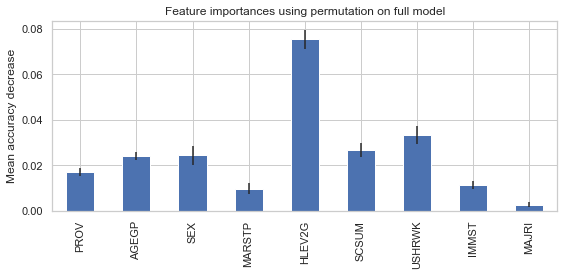

In [37]:
from sklearn.linear_model import LogisticRegression
logist_reg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight=dictionary)
) 
logist_reg_model.fit(X_train, y_train)
print(logist_reg_model.score(X_train, y_train))
print(logist_reg_model.score(X_valid, y_valid))
print(classification_report(y_valid, logist_reg_model.predict(X_valid), target_names=df['CLASS'].unique()))
models.feature_imp(logist_reg_model, X_valid, y_valid)


### Random Forest Classifier

0.3978345050565811
0.38987256118191044
              precision    recall  f1-score   support

         Low       0.57      0.61      0.59      2208
Lower-middle       0.37      0.40      0.38      2220
      Middle       0.38      0.13      0.20      2219
Upper-middle       0.18      0.65      0.28       444
       Upper       0.37      0.36      0.36      1776

    accuracy                           0.39      8867
   macro avg       0.37      0.43      0.36      8867
weighted avg       0.41      0.39      0.38      8867



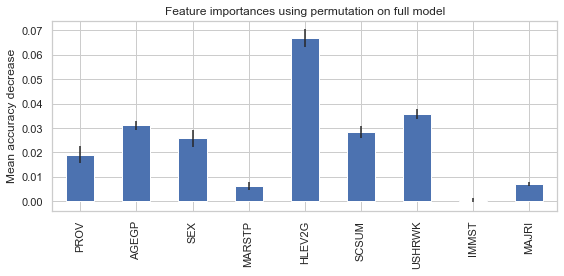

In [38]:
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_leaf=10, class_weight = dictionary)
)
rf_model.fit(X_train, y_train)
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_valid, y_valid))
print(classification_report(y_valid, rf_model.predict(X_valid), target_names=df['CLASS'].unique()))
models.feature_imp(rf_model, X_valid, y_valid)

### Support Vector Classifier

0.3595247941651942
0.35908424495319724
              precision    recall  f1-score   support

         Low       0.55      0.56      0.55      2208
Lower-middle       0.36      0.32      0.34      2220
      Middle       0.35      0.21      0.26      2219
Upper-middle       0.15      0.60      0.24       444
       Upper       0.34      0.29      0.31      1776

    accuracy                           0.36      8867
   macro avg       0.35      0.39      0.34      8867
weighted avg       0.39      0.36      0.36      8867



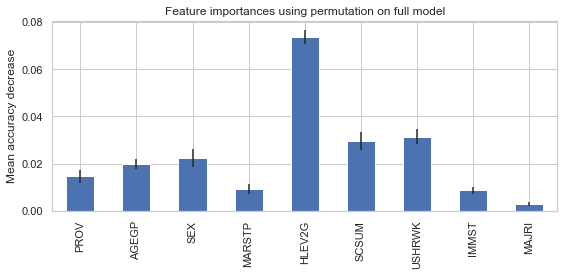

In [40]:
svc_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', C=1.0, class_weight = dictionary)
)
svc_model.fit(X_train, y_train) 
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_valid, y_valid))
print(classification_report(y_valid, svc_model.predict(X_valid), target_names=df['CLASS'].unique()))
models.feature_imp(svc_model, X_valid, y_valid)